# Hyperspectral Unmixing Using Deep Image Prior

In [11]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import cv2
import os
from sklearn.preprocessing import MinMaxScaler
import pysptools.eea as eea
 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

## Variables

Please choose the dataset by setting the value 0:Urban, 1:Jasper, 2:Samson

And if you want to create a video of how the abundance map was estimated (remember to delete the temporary frames)

In [12]:
dataset = 1 
createvid = False
savefigs = False

## Define the model as described in the article

In [13]:


# Define the neural network architecture as defined in the paper
class UnmixingNet(nn.Module):
    def __init__(self, r, padding):
        super(UnmixingNet, self).__init__()
        self.padding = padding
        self.pad = nn.ReflectionPad2d((0,0,0,0))
        if(padding) : #Used if the image shape is odd
            self.pad = nn.ReflectionPad2d((1,0,1,0))
        self.conv1 = nn.Conv2d(r, 256, kernel_size=3, stride=2, padding_mode="reflect", padding=1)
        self.batch_norm1 = nn.BatchNorm2d(256)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding_mode="reflect", padding=1)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.batch_norm_up = nn.BatchNorm2d(260)
        self.conv3 = nn.Conv2d(260, 256, kernel_size=3, stride=1, padding_mode="reflect", padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding_mode="reflect")
        self.batch_norm4 = nn.BatchNorm2d(256)
        self.leaky_relu4 = nn.LeakyReLU(negative_slope=0.1)
        self.conv5 = nn.Conv2d(256, r, kernel_size=1, stride=1, padding_mode="reflect")
        self.softmax = nn.Softmax(dim=1)
        self.conv_skip = nn.Conv2d(r, 4, kernel_size=1, stride=1, padding_mode="reflect")
        self.batch_norm_skip = nn.BatchNorm2d(4)
        self.leaky_relu_skip = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):

      padded = self.pad(x)
      #print("input size =", padded.size())
      
      conv1_out = self.conv1(padded)
      #print("conv1 =", conv1_out.size())
      
      bn1_out = self.batch_norm1(conv1_out)
      #print("bn1 =", bn1_out.size())
      
      leaky_relu1_out = self.leaky_relu1(bn1_out)
      #print("lrelu1 =", leaky_relu1_out.size())
      
      conv2_out = self.conv2(leaky_relu1_out)
      #print("conv2 =", conv2_out.size())
      
      bn2_out = self.batch_norm2(conv2_out)
      #print("bn2 =", bn2_out.size())
      
      leaky_relu2_out = self.leaky_relu1(bn2_out)
      #print("lrelu2 =", leaky_relu2_out.size())
      
      upsample_out = self.upsample(leaky_relu2_out)
      #print("upsample =", upsample_out.size())
      
      conv_skip_out = self.conv_skip(padded)
      #print("convskip =", conv_skip_out.size())
      
      bn_skip_out = self.batch_norm_skip(conv_skip_out)
      #print("bn_skip =", bn_skip_out.size())
      
      leaky_relu_skip_out = self.leaky_relu1(bn_skip_out)
      #print("lrelu_skip =", leaky_relu_skip_out.size())
      
      conv3_input = self.batch_norm_up(torch.cat((leaky_relu_skip_out, upsample_out), dim=1))
      #print("conv3_input =", conv3_input.size())
      
      conv3_out = self.conv3(conv3_input)
      #print("conv3 =", conv3_out.size())
      
      bn3_out = self.batch_norm3(conv3_out)
      #print("bn3 =", bn3_out.size())
      
      leaky_relu3_out = self.leaky_relu1(bn3_out)
      #print("lrelu3 =", leaky_relu3_out.size())
      
      conv4_out = self.conv4(leaky_relu3_out)
      #print("conv4 =", conv4_out.size())
      
      bn4_out = self.batch_norm4(conv4_out)
      #print("bn4 =", bn4_out.size())
      
      leaky_relu4_out = self.leaky_relu1(bn4_out)
      #print("lrelu4 =", leaky_relu4_out.size())
      
      conv5_out = self.conv5(leaky_relu4_out)
      #print("conv5 =", conv5_out.size())
      
      output = self.softmax(conv5_out)
      #print(output[:,:,1:,1:].size())
      
      if(self.padding) :
        return output[:,:,1:,1:]
      return output






## Dataset loader

In [14]:
#Choose dataset 0:Urban, 1:Jasper, 2:Samson
def load_dataset(dataset=0, printing=True):
    if(dataset==0):
        data = sci.loadmat('Data/Urban.mat')
        gt = sci.loadmat('Data/end6_groundTruth.mat')
        Y = data['X']
        abundances = gt['A']
        endmembers = gt['M']
        names = ["Road", "Grass", "Tree", "Rooftop", "Metal", "Dirt"]
    if(dataset==1):
        data = sci.loadmat('Data/jasperRidge2_R198.mat')
        gt = sci.loadmat('Data/end4.mat')
        Y = data['Y']
        abundances = gt['A']
        endmembers = gt['M']
        names = ["Tree", "Water", "Dirt", "Road"]
    if(dataset==2):
        data = sci.loadmat('Data/Y_clean.mat')
        A_gt = sci.loadmat('Data/A_true.mat')
        E_gt = sci.loadmat('Data/E.mat')
        Y = data['Y_clean'].transpose(2,0,1)
        Y = Y.reshape(Y.shape[0], Y.shape[1]**2)
        abundances = A_gt['A_true'].transpose(2,0,1)
        abundances = abundances.reshape(abundances.shape[0], abundances.shape[1]**2)
        endmembers = E_gt['E']
        names = ["Water", "Soil", "Tree"]
    p = Y.shape[0]
    n = Y.shape[1]
    r = endmembers.shape[1]
    Y = Y.astype(float)
    if(printing):
        print(f"Y before scaling Max: {np.format_float_positional(np.max(Y))}  Min: {np.format_float_positional(np.min(Y))}  Mean: {np.format_float_positional(np.mean(Y))}  Std: {np.format_float_positional(np.std(Y))}")
    Y = Y/np.max(Y)
    return Y, abundances, endmembers, p, n, r, names

        


## Data exploration

Y before scaling Max: 5437.  Min: 0.  Mean: 1194.1434484848485  Std: 1031.883607511436
Y after scaling Max: 1.  Min: 0.  Mean: 0.21963278434519914  Std: 0.18978914980898212
Abundance Max: 1.0000000000000002  Min: 0.  Mean: 0.25  Std: 0.3497529508863477
Endmember Max: 0.6290566037735849  Min: 0.  Mean: 0.27023433672857156  Std: 0.19448823614872807
X Max: 0.6290566037735849  Min: 0.  Mean: 0.22948484265564528  Std: 0.17766093984342912


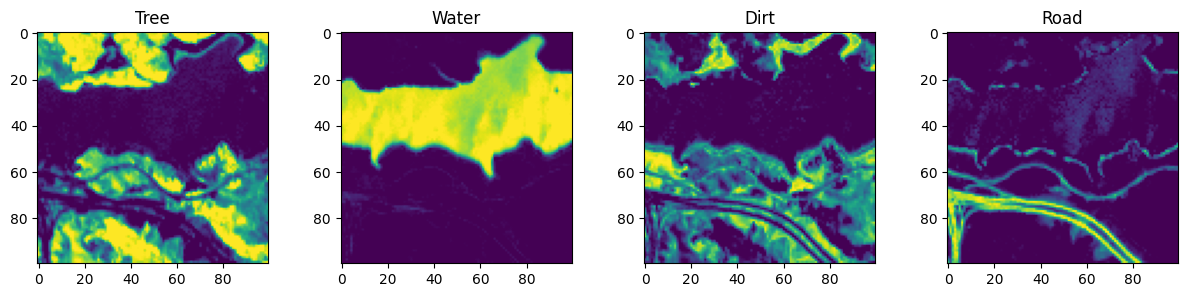

In [15]:

Y, abundances, endmembers, p, n, r, names= load_dataset(dataset)
X = endmembers @ abundances


print(f"Y after scaling Max: {np.format_float_positional(np.max(Y))}  Min: {np.format_float_positional(np.min(Y))}  Mean: {np.format_float_positional(np.mean(Y))}  Std: {np.format_float_positional(np.std(Y))}")
print(f"Abundance Max: {np.format_float_positional(np.max(abundances))}  Min: {np.format_float_positional(np.min(abundances))}  Mean: {np.format_float_positional(np.mean(abundances))}  Std: {np.format_float_positional(np.std(abundances))}")
print(f"Endmember Max: {np.format_float_positional(np.max(endmembers))}  Min: {np.format_float_positional(np.min(endmembers))}  Mean: {np.format_float_positional(np.mean(endmembers))}  Std: {np.format_float_positional(np.std(endmembers))}")
print(f"X Max: {np.format_float_positional(np.max(X))}  Min: {np.format_float_positional(np.min(X))}  Mean: {np.format_float_positional(np.mean(X))}  Std: {np.format_float_positional(np.std(X))}")

nCol = np.sqrt(n).astype(int)
nRow = np.sqrt(n).astype(int)
plt.figure(figsize=(15, 3))

for ii in range(r): 
    ax = plt.subplot(1, r, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    plt.title(names[ii])


As we can see before scaling the observed hyperspectral image $Y$ has a greater range of values compared to the ground truth hyperspectral image $X = EA$ before scaling. Which can impact the gradient descent when we want to minimize the reconstruction loss.

## Training the model

Y before scaling Max: 5437.  Min: 0.  Mean: 1194.1434484848485  Std: 1031.883607511436
torch.Size([198, 10000])
torch.Size([4, 10000])
torch.Size([198, 4])
0.0021958656143397093
Epoch: 300/3000, Loss: 0.0008193381363525987, mae: 0.043180759996175766


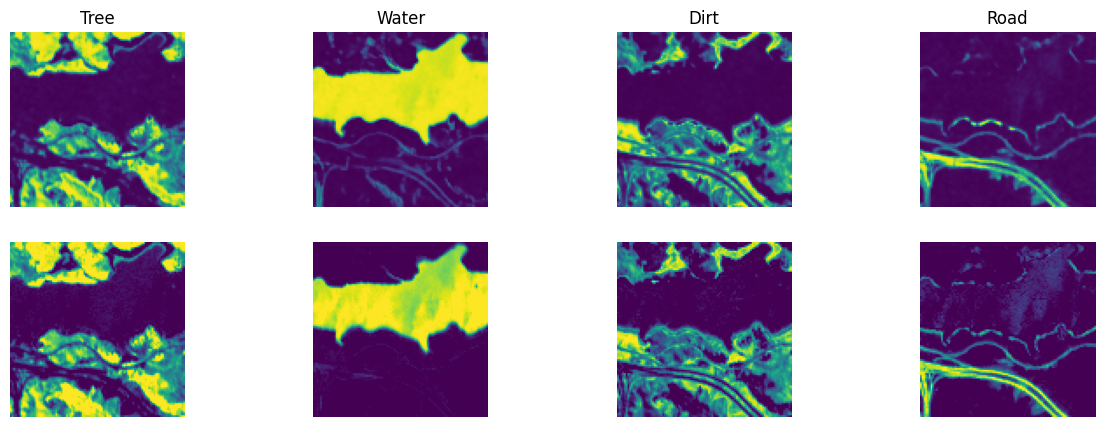

Epoch: 600/3000, Loss: 0.0008165758918039501, mae: 0.041245847940444946


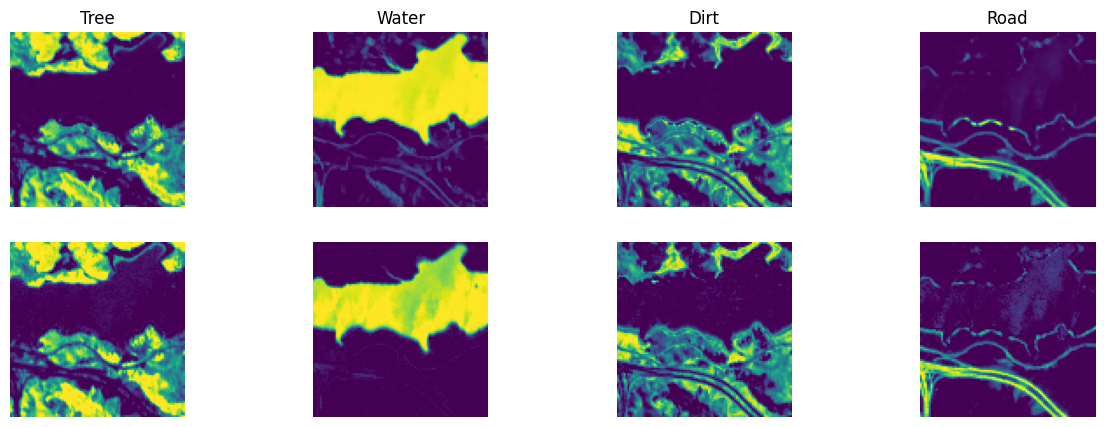

Epoch: 900/3000, Loss: 0.0007987413555383682, mae: 0.040796756744384766


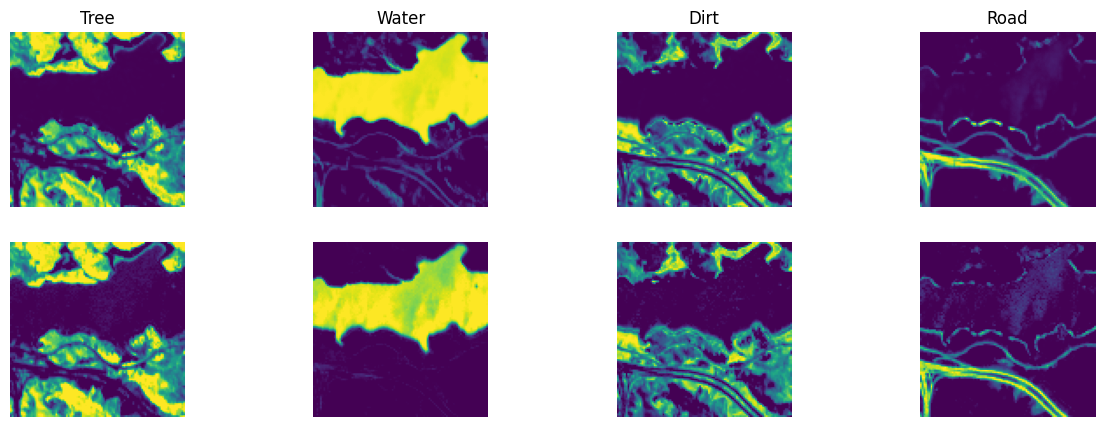

Epoch: 1200/3000, Loss: 0.000800986192189157, mae: 0.0409521609544754


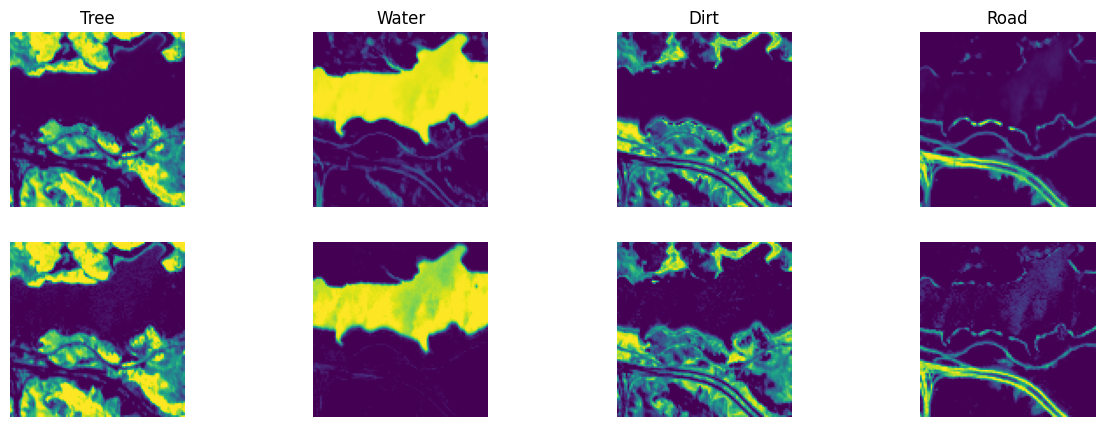

Epoch: 1500/3000, Loss: 0.0008118454716168344, mae: 0.040695920586586


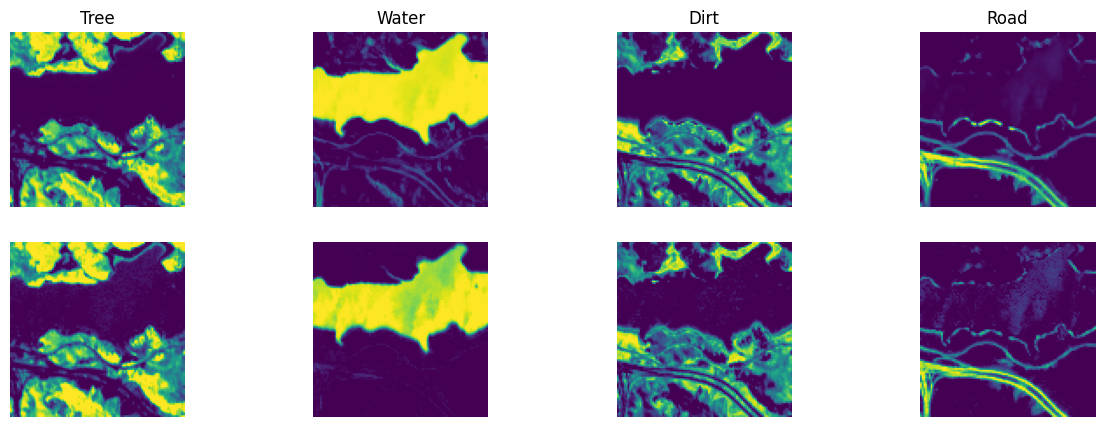

Epoch: 1800/3000, Loss: 0.0007938368944451213, mae: 0.04010429605841637


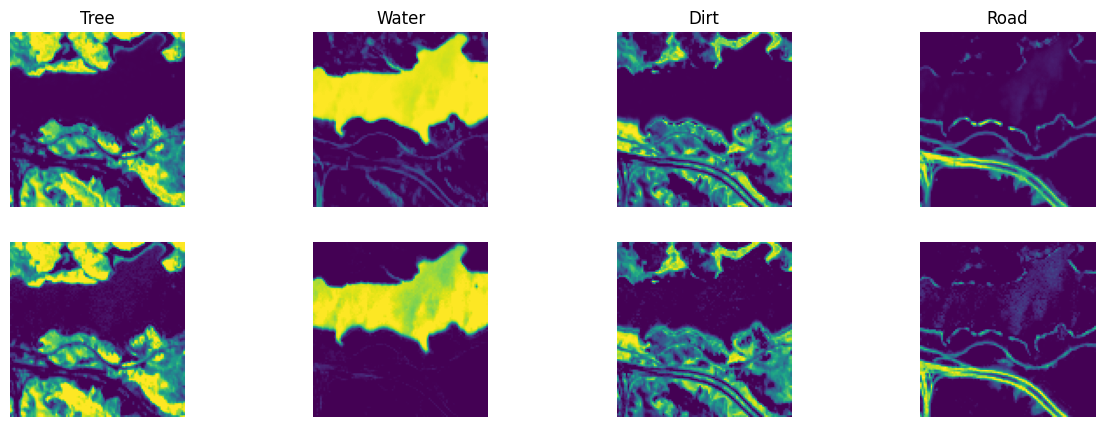

Epoch: 2100/3000, Loss: 0.0007939174538478255, mae: 0.039994336664676666


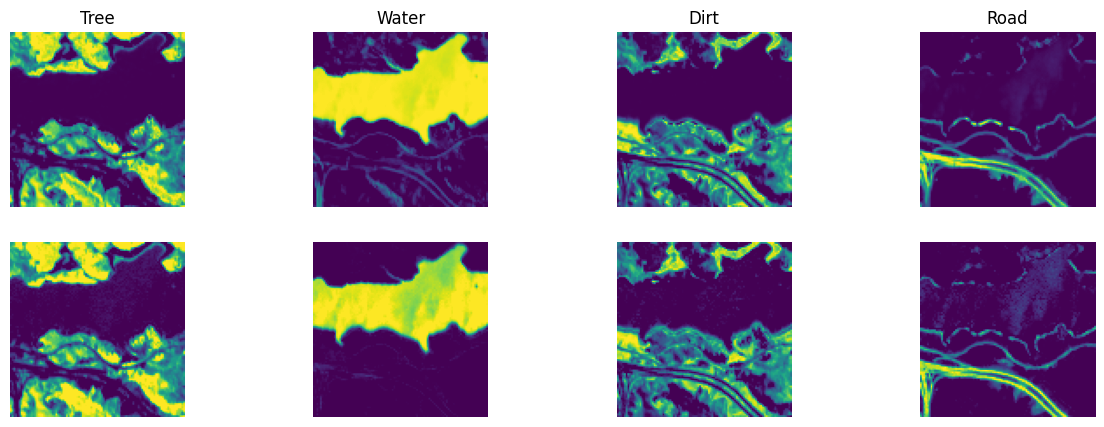

Epoch: 2400/3000, Loss: 0.0007937861373648047, mae: 0.04010173678398132


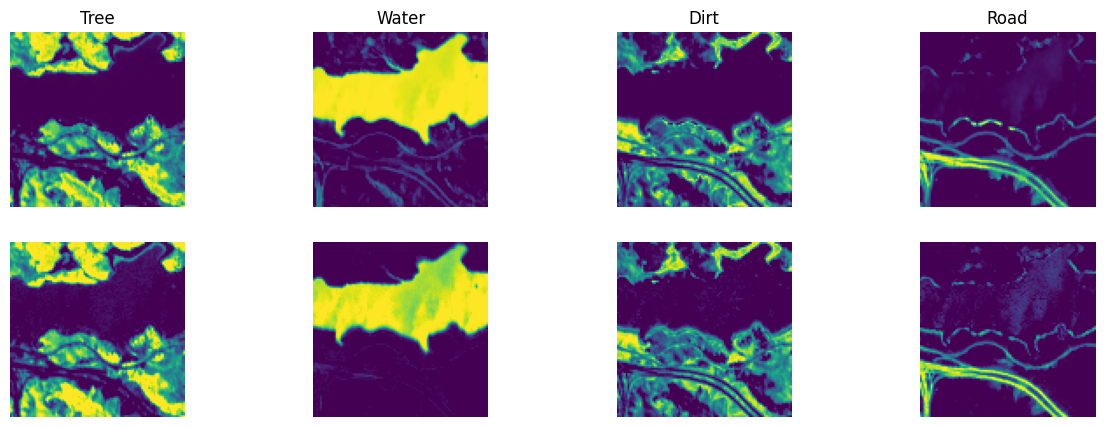

Epoch: 2700/3000, Loss: 0.0007927201804704964, mae: 0.03993591293692589


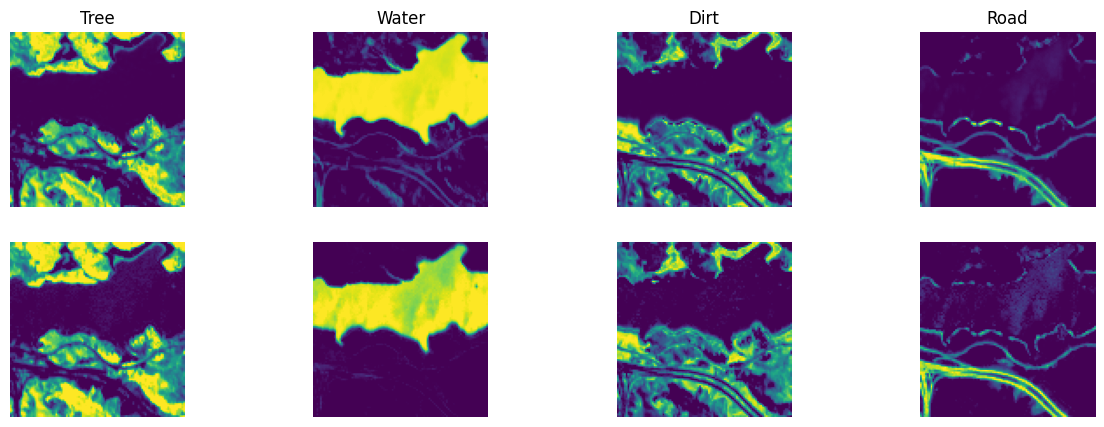

Epoch: 3000/3000, Loss: 0.0007934616878628731, mae: 0.039893463253974915


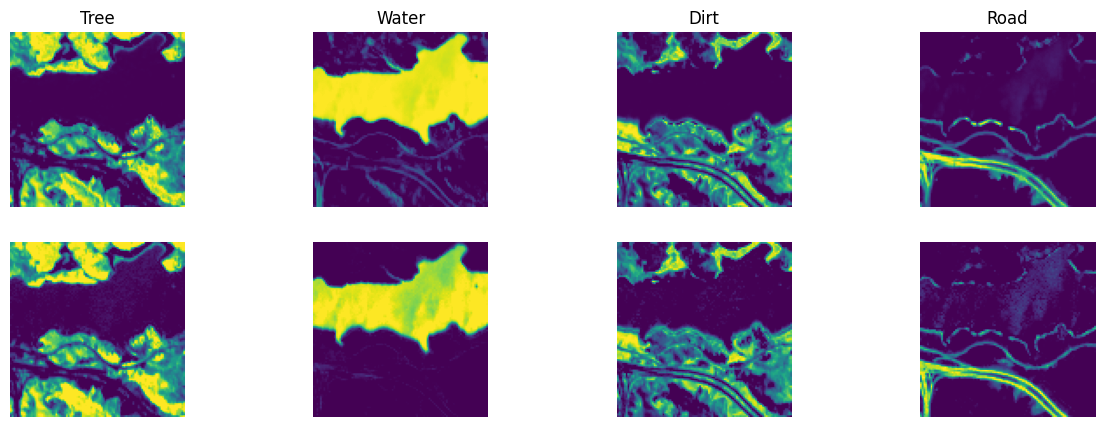

In [16]:
# Set hyperparameters
learning_rate = 0.001
num_iterations = 3000
if(dataset==0):
    output_frames = "urban_output/urban_frames"
if(dataset==1):
    output_frames = "jasper_output/jasper_frames"
if(dataset==2):
    output_frames = "samson_output/samson_frames"
os.makedirs(output_frames, exist_ok=True)

# Prepare the data
Y, abundances, endmembers, p, n, r, names= load_dataset(dataset, False)
nCol = np.sqrt(n).astype(int)
nRow = np.sqrt(n).astype(int)

# Convert the data to PyTorch tensors
Y_tensor = torch.from_numpy(Y).float().to(device)
print(Y_tensor.size())
abundances_tensor = torch.from_numpy(abundances).float().to(device)
print(abundances_tensor.size())
endmember_tensor = torch.from_numpy(endmembers).float().to(device)
print(endmember_tensor.size())


# Create an instance of the UnmixingNet
model = UnmixingNet(r, nRow%2==1)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mean_absolute_error = nn.L1Loss()
mean_absolute_error.to(device)

print(criterion(endmember_tensor @ abundances_tensor, Y_tensor).item())

loss_array = []
ab_mae = []
ab_mae_exp = []
out_avg = None

# Generate a random image as input for abundance estimation
random_image = torch.rand(1,r,nCol,nRow, device=device).float()
# Training loop
for epoch in range(num_iterations):

    # Estimate abundances using the network and endmembers
    predicted_abundances = model(random_image)

    # Compute the loss using the predicted abundances, endmembers, and ground truth image
    tmp_ab = predicted_abundances.reshape(r, n).to(device)
    
    if out_avg is None:
        out_avg = tmp_ab
    else:
        out_avg =  out_avg * 0.99 + tmp_ab * 0.01
        
    Xhat = endmember_tensor @ tmp_ab
    Xhat.to(device)
    #compute the loss and mae of estimated abundances
    loss = criterion(Xhat, Y_tensor)
    mae = mean_absolute_error(tmp_ab, abundances_tensor)
    mae_exp = mean_absolute_error(out_avg, abundances_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Create the subplots without displaying them
    fig, axes = plt.subplots(2, r, figsize=(15, 5))

    #Save the estimated abundance after every iterations
    file_name = f"frame_{epoch+1:04}.png"
    for ii in range(r): 
        axes[0][ii].imshow(out_avg.detach().cpu().numpy()[ii, :].reshape(nCol, nRow))
        axes[1][ii].imshow(abundances[ii,:].reshape(nCol,nRow))
        axes[0][ii].set_title(names[ii])
        axes[0][ii].axis('off')  # Turn off the axis labels and ticks
        axes[1][ii].axis('off')  # Turn off the axis labels and ticks
    if(createvid) :
        plt.savefig(os.path.join(output_frames, file_name))

    # Print the loss for every 300 iterations
    if((epoch + 1) % 300 == 0):
        print(f"Epoch: {epoch+1}/{num_iterations}, Loss: {loss.item()}, mae: {mae.item()}")
        plt.show()
    
    plt.close()
        
    
    loss_array.append(loss.item())
    ab_mae.append(mae.item())
    ab_mae_exp.append(mae_exp.item())
    

estimated_abundances = model(random_image).detach().cpu().numpy()

# You can access the estimated abundances as a numpy array using estimated_abundances.detach().numpy()



## Comparaison between the Spectral RMSE of the estimated abundance obtained via a forward pass and the sliding window

0.03702407021739382
0.03703186094788885


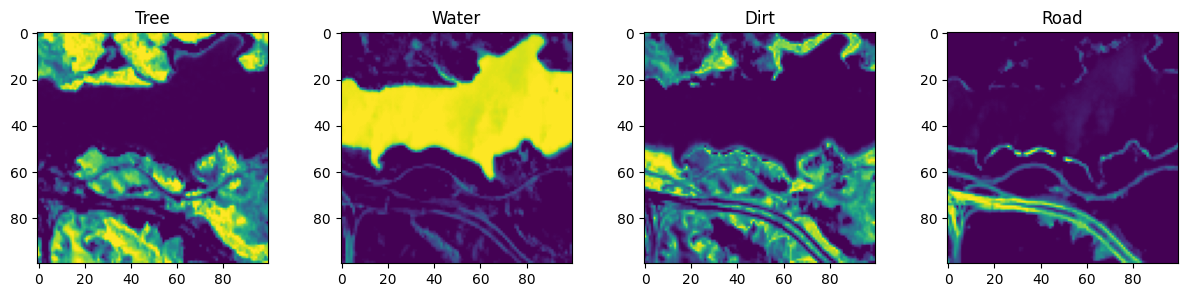

In [17]:
est=out_avg.detach().cpu().numpy().reshape(r,n)
plt.figure(figsize=(15, 3))

for ii in range(r): 
    ax = plt.subplot(1, r, ii+1)
    ax.imshow(est[ii].reshape(nCol, nRow))
    plt.title(names[ii])


diff = X - endmembers @ est
sum = np.sqrt(np.sum(diff**2)/(n*p))
print(sum) #Spectral RMSE of the estimated abundance using exponential averaging
diff = X - endmembers @ estimated_abundances[0].reshape(r,n)
sum = np.sqrt(np.sum(diff**2)/(n*p))
print(sum)#Spectral RMSE of the estimated abundance  without using exponential averaging

## Video creation from the frames

In [18]:

# Generate video from frames
if(createvid):
    if(dataset==0):
        output_video = "urban_output/urban_video.mp4"
        output_dir = "urban_output/urban_frames"
    if(dataset==1):
        output_video = "jasper_output/jasper_video.mp4"
        output_dir = "jasper_output/jasper_frames"
    if(dataset==2):
        output_video = "samson_output/samson_video.mp4"
        output_dir = "samson_output/samson_frames"

        
    frame_files = sorted(os.listdir(output_dir))
    frame_paths = [os.path.join(output_dir, file) for file in frame_files]

    # Load the first frame to get the frame size
    frame = cv2.imread(frame_paths[0])
    height, width, _ = frame.shape

    # Create a VideoWriter object to write the frames to a video file
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video, fourcc, 24, (width, height))

    # Write each frame to the video file
    for frame_path in frame_paths:
        frame = cv2.imread(frame_path)
        video_writer.write(frame)

    # Release the VideoWriter and clean up
    video_writer.release()
    cv2.destroyAllWindows()




## Displaying and saving the plot of the losses

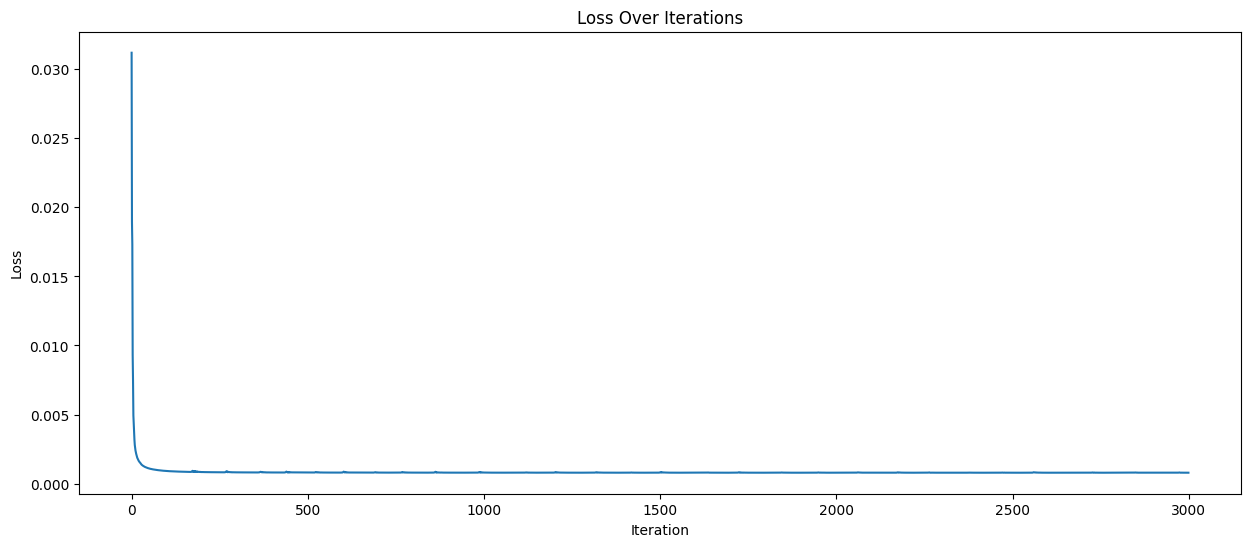

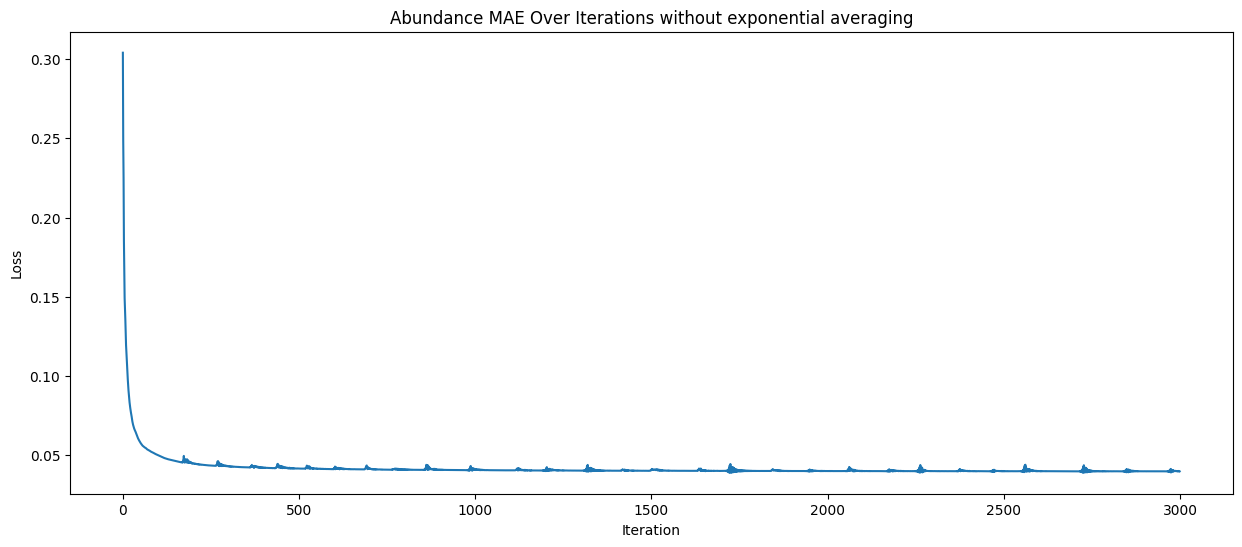

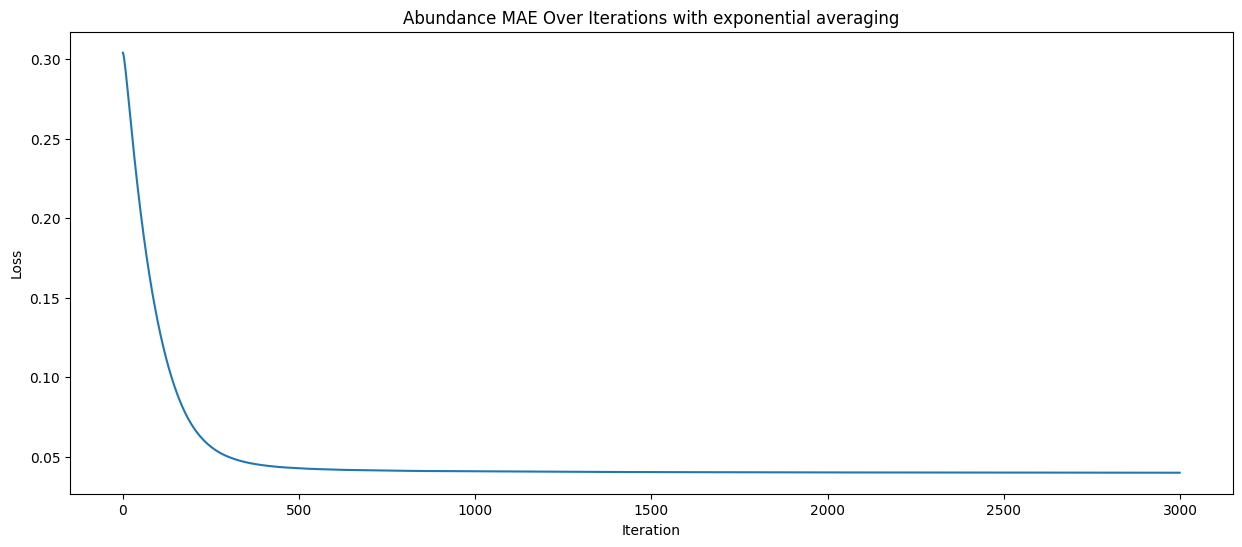

In [19]:

if(dataset==0):
    output_dir = "urban_output/plots"
if(dataset==1):
    output_dir = "jasper_output/plots"
if(dataset==2):
    output_dir = "samson_output/plots"

plt.figure(figsize=(15, 6))

plt.plot(loss_array)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Iterations')
if(savefigs):
    plt.savefig(os.path.join(output_dir, "Loss_Over_Iterations.png"))
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(ab_mae)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Abundance MAE Over Iterations without exponential averaging')
if(savefigs):
    plt.savefig(os.path.join(output_dir, "Abundance_MAE_Over_Iterations_noexp.png"))
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(ab_mae_exp)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Abundance MAE Over Iterations with exponential averaging')
if(savefigs):
    plt.savefig(os.path.join(output_dir, "Abundance_MAE_Over_Iterations_exp.png"))
plt.show()